# <center>Bad Bank Behavior<br>Analyzing Bank Mortgage during the 2007 Housing Bubble</center>  

<center>Michael Siebel</center>
<center>August 2020</center>
<br>

## <center>Model Selection Script</center>

# Purpose  
<br>

> Runs a relative importance analysis called permutation importance to determine the most important features in each of the algorithms that will be modelled subsequently.  Features with low importance may be subject for removal from the model selection.

> The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

***

# Load Functions

In [1]:
%run Functions.ipynb
pd.set_option("display.max_columns", 200)
pd.set_option('display.max_rows', 200)

file_to_open = open('..\Data\df.pkl', 'rb') 
df  = pickle.load(file_to_open) 
file_to_open.close()

# Drop mergeID column
df = df.drop(labels='Loan ID', axis=1)

# Convert Inf values to NA
df = df.replace([np.inf, -np.inf], np.nan)

***

# Set Up Data

In [2]:
print('Shape:\n', df.shape)
print('\nColumns:\n', df.columns)

Shape:
 (2332683, 56)

Columns:
 Index(['Origination Channel', 'Bank', 'Original Interest Rate',
       'Original Mortgage Amount', 'Original Loan Term', 'Original Date',
       'Original Combined Loan-to-Value (CLTV)', 'Single Borrower',
       'Original Debt to Income Ratio', 'First Time Home Buyer',
       'Loan Purpose', 'Property Type', 'Occupancy Type', 'Property State',
       'Zip Code', 'Mortgage Insurance %', 'Mortgage Insurance Type',
       'File Year', 'File Quarter', 'Foreclosed', 'Month', 'Year',
       'Harmonized Credit Score', 'Loan Change (1 Year)',
       'Loan Change (5 Years)', 'Median Household Income', 'Region',
       'Household Financial Obligations (Qtr)',
       'Household Financial Obligations (Yr)',
       'Consumer Debt Service Payment (Qtr)',
       'Consumer Debt Service Payment (Yr)', 'National Home Price Index (Qtr)',
       'National Home Price Index (Yr)',
       'Mortgage Debt Service Payments (Qtr)',
       'Mortgage Debt Service Payments (Yr)', '

In [3]:
# Banks
df['Bank'].value_counts()

BANK OF AMERICA, N.A.                        622582
OTHER                                        460374
CITIMORTGAGE, INC.                           249101
SMALL LOAN BANKS                             213184
GMAC MORTGAGE                                172160
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION    144934
SUNTRUST MORTGAGE INC.                       130160
PNC BANK, N.A.                                94593
AMTRUST BANK                                  76340
FLAGSTAR CAPITAL MARKETS CORPORATION          63368
FIRST TENNESSEE BANK NATIONAL ASSOCIATION     57180
CHASE HOME FINANCE                            38741
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB       9966
Name: Bank, dtype: int64

In [4]:
# Drop "OTHER"  and "SMALL LOAN BANKS" Categories
df = df[df['Bank'] != 'OTHER']
df = df[df['Bank'] != 'SMALL LOAN BANKS']
df['Bank'].value_counts()

BANK OF AMERICA, N.A.                        622582
CITIMORTGAGE, INC.                           249101
GMAC MORTGAGE                                172160
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION    144934
SUNTRUST MORTGAGE INC.                       130160
PNC BANK, N.A.                                94593
AMTRUST BANK                                  76340
FLAGSTAR CAPITAL MARKETS CORPORATION          63368
FIRST TENNESSEE BANK NATIONAL ASSOCIATION     57180
CHASE HOME FINANCE                            38741
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB       9966
Name: Bank, dtype: int64

In [5]:
# Variables for One Hot encoding
df_cat = df.select_dtypes(include=['object'])
df_cat.tail()

,Origination Channel,Bank,Original Date,First Time Home Buyer,Property Type,Occupancy Type,Property State,File Year,File Quarter,Month,Year,Region
1091732,B,"CITIMORTGAGE, INC.",12/2006,Y,CO,P,IL,2006,Q4,12,2006,Midwest
1091737,R,GMAC MORTGAGE,12/2006,N,SF,P,NV,2006,Q4,12,2006,West
1091739,B,"BANK OF AMERICA, N.A.",12/2006,N,MH,P,AZ,2006,Q4,12,2006,West
1091744,B,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,12/2006,N,SF,P,VA,2006,Q4,12,2006,South
1091745,R,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,12/2006,N,SF,I,NC,2006,Q4,12,2006,South


In [6]:
# Variables to drop
dropvars = ['Original Date', 'File Year', 'File Quarter', 'Month', 'Year', 'Region',
            'Zip Code', 'Mortgage Insurance Type']  # 'Property State', 

# All data
df = df.drop(labels=dropvars, axis=1)
df = df.dropna()
All_y = df['Foreclosed']
All_X = df.drop(labels='Foreclosed', axis=1) 


# Cut dataset in half for faster runtimes
X_train, X_test, y_train, y_test = train_test_split(All_X, All_y, test_size = 0.3, 
                                                    stratify = All_y, random_state=2019)

# One hot encoding on remaining data
X_train = onehotencoding(X_train)
X_train = X_train.drop(labels=['First Time Home Buyer_U'], axis=1)
X_test = onehotencoding(X_test)
X_test = X_test.drop(labels=['First Time Home Buyer_U'], axis=1)

# Save columns
X_cols = X_train.columns

print('Shape:', X_train.shape)

Shape: (1077261, 116)


***

# Missingness

In [7]:
# Missing
print((X_train.isna().sum() / X_train.shape[0] * 100).round(2))

Original Interest Rate                            0.0
Original Mortgage Amount                          0.0
Original Loan Term                                0.0
Original Combined Loan-to-Value (CLTV)            0.0
Single Borrower                                   0.0
Original Debt to Income Ratio                     0.0
Loan Purpose                                      0.0
Mortgage Insurance %                              0.0
Harmonized Credit Score                           0.0
Loan Change (1 Year)                              0.0
Loan Change (5 Years)                             0.0
Median Household Income                           0.0
Household Financial Obligations (Qtr)             0.0
Household Financial Obligations (Yr)              0.0
Consumer Debt Service Payment (Qtr)               0.0
Consumer Debt Service Payment (Yr)                0.0
National Home Price Index (Qtr)                   0.0
National Home Price Index (Yr)                    0.0
Mortgage Debt Service Paymen

In [8]:
'''
# impute using KNN
imp_cols = ['numemp', 'asset (5 Yr)', 'asset (1 Yr)', 'lnlsnet (5 Yr)', 
            'lnlsnet (1 Yr)', 'liab (5 Yr)', 'liab (1 Yr)', 'dep (5 Yr)', 
            'dep (1 Yr)', 'eqtot (5 Yr)', 'eqtot (1 Yr)', 
            'Original Combined Loan-to-Value (CLTV)', 'Original Debt to Income Ratio',
            'Harmonized Credit Score']
X_train = KNN_imputations(df_X=X_train, df_y=y_train, X_cols=imp_cols, n_neighbors=3)

# Missing
X_train[imp_cols].isna().sum()
'''

"\n# impute using KNN\nimp_cols = ['numemp', 'asset (5 Yr)', 'asset (1 Yr)', 'lnlsnet (5 Yr)', \n            'lnlsnet (1 Yr)', 'liab (5 Yr)', 'liab (1 Yr)', 'dep (5 Yr)', \n            'dep (1 Yr)', 'eqtot (5 Yr)', 'eqtot (1 Yr)', \n            'Original Combined Loan-to-Value (CLTV)', 'Original Debt to Income Ratio',\n            'Harmonized Credit Score']\nX_train = KNN_imputations(df_X=X_train, df_y=y_train, X_cols=imp_cols, n_neighbors=3)\n\n# Missing\nX_train[imp_cols].isna().sum()\n"

In [9]:
def pca_fred(X_train=X_train, X_test=X_test, n_components=4):
    # FRED Subset
    columns = ['Household Financial Obligations (Qtr)', 'Household Financial Obligations (Yr)', 
         'Consumer Debt Service Payment (Qtr)', 'Consumer Debt Service Payment (Yr)',
         'National Home Price Index (Qtr)', 'National Home Price Index (Yr)',
         'Mortgage Debt Service Payments (Qtr)', 'Mortgage Debt Service Payments (Yr)',
         'Monthly Supply of Houses (Qtr)', 'Monthly Supply of Houses (Yr)',
         'Vacant Housing Units for Sale (Qtr)', 'Vacant Housing Units for Sale (Yr)',
         'Homeownership Rate (Qtr)', 'Homeownership Rate (Yr)', 'Vacant Housing Units for Rent (Qtr)',
         'Vacant Housing Units for Rent (Yr)', 'Rental Vacancy Rate (Qtr)', 'Rental Vacancy Rate (Yr)']
    fred_train =  X_train[columns]
    fred_test = X_test[columns]
    
    # Fit PCA
    dimredu = PCA(n_components=n_components, random_state=2020).fit(fred_train)
    fred_train = pd.DataFrame(dimredu.transform(fred_train), columns=['Macroeconomy PCA 1',
                                                                      'Macroeconomy PCA 2',
                                                                      'Macroeconomy PCA 3',
                                                                      'Macroeconomy PCA 4'])
    fred_test = pd.DataFrame(dimredu.transform(fred_test), columns=['Macroeconomy PCA 1',
                                                                    'Macroeconomy PCA 2',
                                                                    'Macroeconomy PCA 3',
                                                                    'Macroeconomy PCA 4'])
    
    # Subsitute PCA columns
    X_train = X_train.drop(labels=columns, axis=1)
    X_train = pd.concat([X_train, fred_train], axis=1)
    X_test = X_test.drop(labels=columns, axis=1)
    X_test = pd.concat([X_test, fred_test], axis=1)
    
    return X_train, X_test

In [10]:
# Update Macroeconomic variables (will not use test set)
from sklearn.decomposition import PCA
X_train, X_test = pca_fred(X_train, X_test, n_components=4)

# Save columns
X_cols = X_train.columns
X_cols

Index(['Original Interest Rate', 'Original Mortgage Amount',
       'Original Loan Term', 'Original Combined Loan-to-Value (CLTV)',
       'Single Borrower', 'Original Debt to Income Ratio', 'Loan Purpose',
       'Mortgage Insurance %', 'Harmonized Credit Score',
       'Loan Change (1 Year)',
       ...
       'Property State_VA', 'Property State_VT', 'Property State_WA',
       'Property State_WI', 'Property State_WV', 'Property State_WY',
       'Macroeconomy PCA 1', 'Macroeconomy PCA 2', 'Macroeconomy PCA 3',
       'Macroeconomy PCA 4'],
      dtype='object', length=102)

***

# Check for Multicolinearity

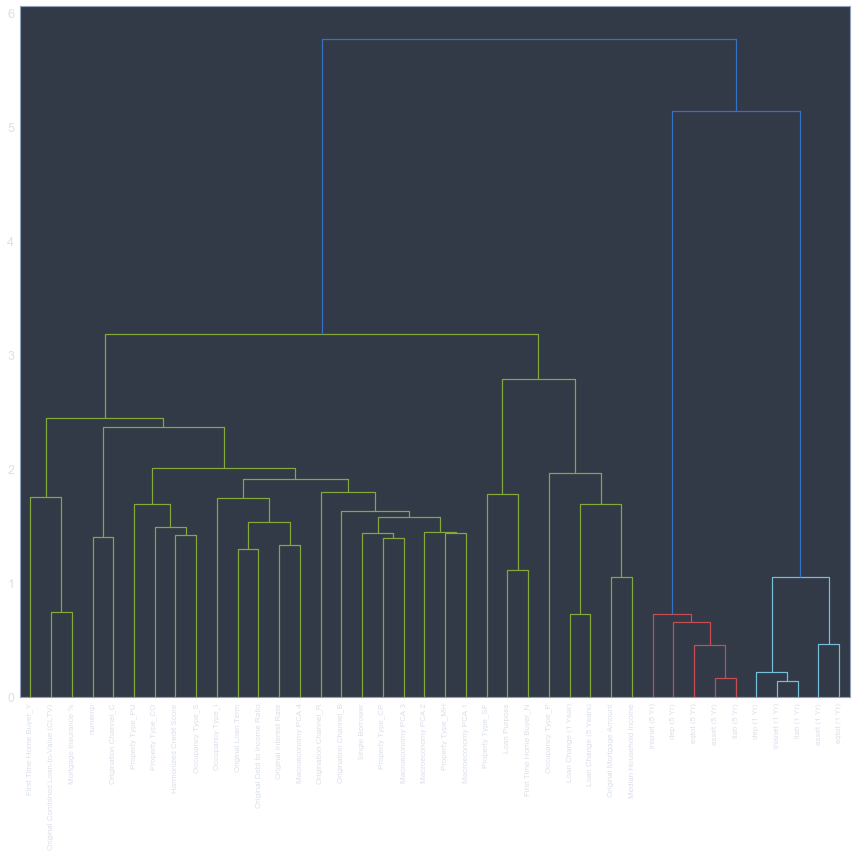

None


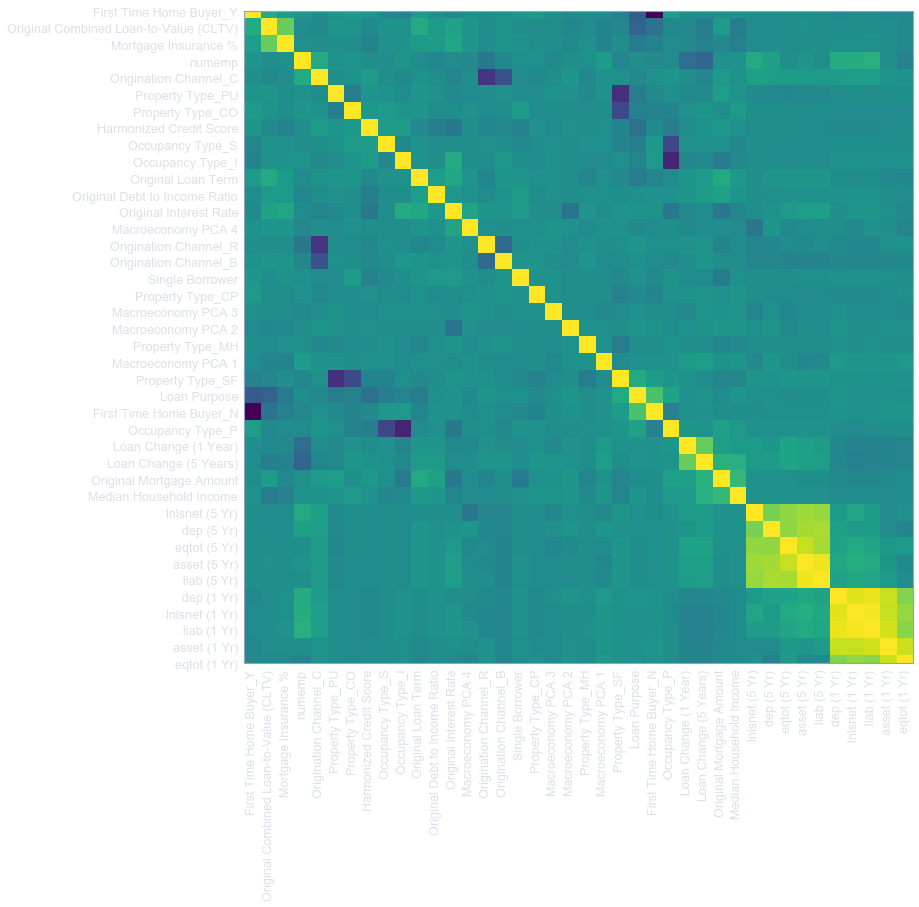

None


In [11]:
X = X_train
X = X.filter(regex=r'^(?!Property State).*$')
X = X.filter(regex=r'^(?!Bank).*$')

fig, ax1 = plt.subplots(figsize=(12, 12))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))
fig.tight_layout()
print(plt.show())

fig, ax2 = plt.subplots(figsize=(12, 12))
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
print(plt.show())

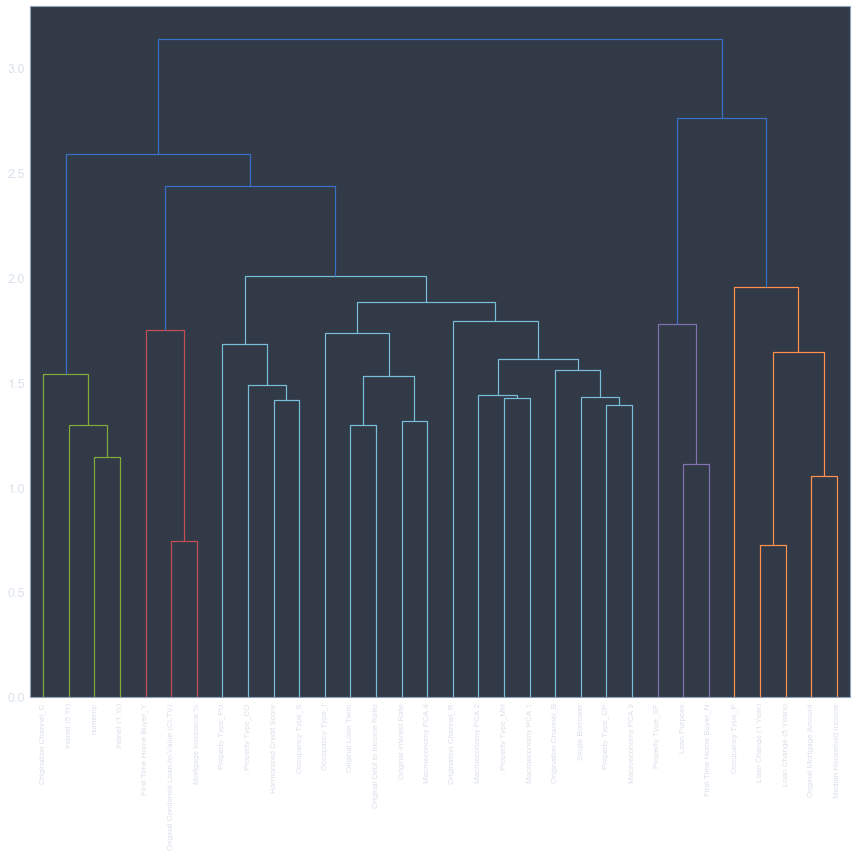

None


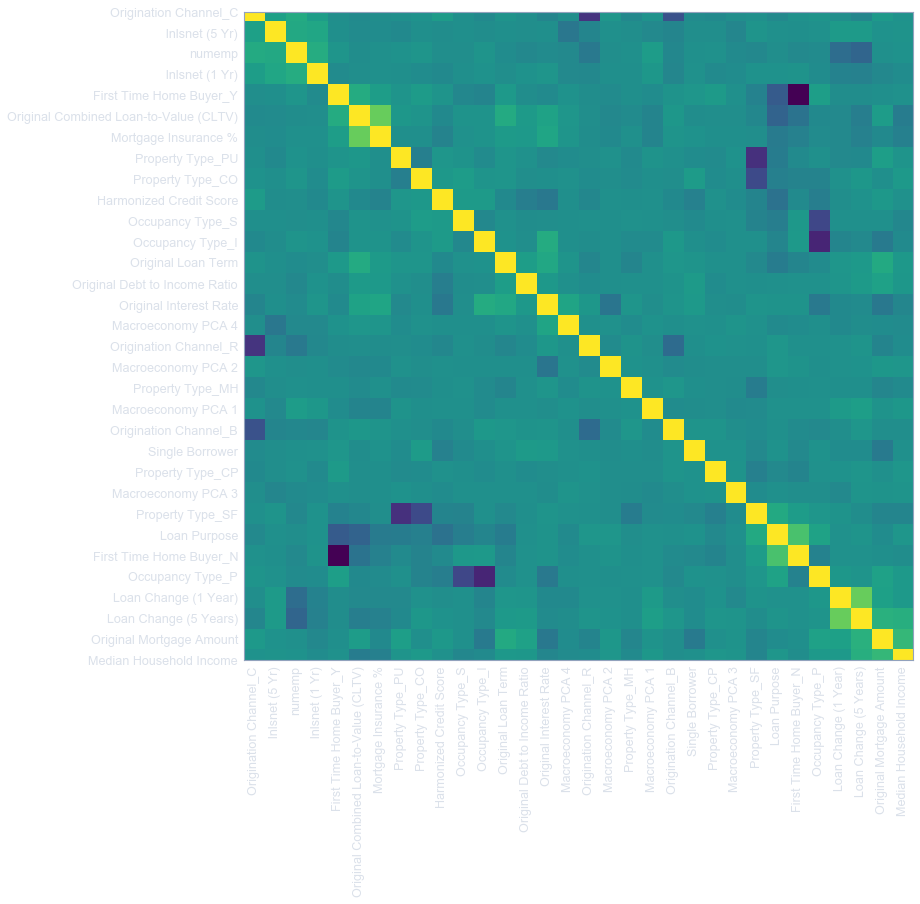

None


In [12]:
X = X_train
X = X.filter(regex=r'^(?!Property State).*$')
X = X.filter(regex=r'^(?!Bank).*$')
X = X.filter(regex=r'^(?!asset).*$')
X = X.filter(regex=r'^(?!liab).*$')
X = X.filter(regex=r'^(?!eqtot).*$')
X = X.filter(regex=r'^(?!dep).*$')

fig, ax1 = plt.subplots(figsize=(12, 12))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))
fig.tight_layout()
print(plt.show())

fig, ax2 = plt.subplots(figsize=(12, 12))
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
print(plt.show())

In [13]:
# Remove multicolinear columns
X_train = X_train.filter(regex=r'^(?!asset).*$')
X_train = X_train.filter(regex=r'^(?!liab).*$')
X_train = X_train.filter(regex=r'^(?!eqtot).*$')
X_train = X_train.filter(regex=r'^(?!dep).*$') 

X_test = X_test.filter(regex=r'^(?!asset).*$')
X_test = X_test.filter(regex=r'^(?!liab).*$')
X_test = X_test.filter(regex=r'^(?!eqtot).*$')
X_test = X_test.filter(regex=r'^(?!dep).*$') 

# List of banks
Banks = ['AMTRUST BANK', 'BANK OF AMERICA, N.A.', 'CITIMORTGAGE, INC.', 
         'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB', 
         'FIRST TENNESSEE BANK NATIONAL ASSOCIATION', 'FLAGSTAR CAPITAL MARKETS CORPORATION', 
         'GMAC MORTGAGE', 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION', 
         'PNC BANK, N.A.', 'SUNTRUST MORTGAGE INC.', 'CHASE HOME FINANCE']

# Create dictionary of subsetted bank data
Banks_X, Banks_y = Bank_Subsets(Banks, df_X = X_train, df_y = y_train)
Banks_X_test, Banks_y_test = Bank_Subsets(Banks, df_X = X_test, df_y = y_test)

# Remove Banks from full data
X_train = X_train.filter(regex=r'^(?!Bank_).*$') 
X_test = X_test.filter(regex=r'^(?!Bank).*$')

# Number of final columns
print('Number of final columns:', len(X_train.columns))

Number of final columns: 83


***

# Recursive Feature Elimination

Optimal number of features : 70
Best F1 Score: 0.31


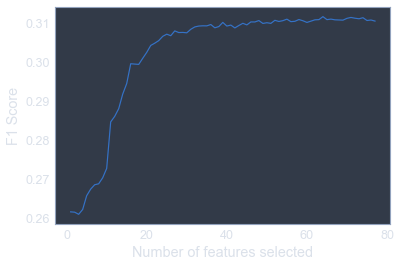

None


In [14]:
# RFE for full data
# Train
y = y_train
X = X_train

# Analysis
rfe_imp_fulbal, subset_fulbal = RFE_importance(X, y, bank_str = 'All Banks', method = 'bal')
    
# Save final results
file_to_store = open("rfe_imp_fulbal.pkl", "wb")
pickle.dump(rfe_imp_fulbal, file_to_store)
file_to_store = open("subset_fulbal.pkl", "wb")
pickle.dump(subset_fulbal, file_to_store)
file_to_store.close()

Optimal number of features : 25
Best F1 Score: 0.06


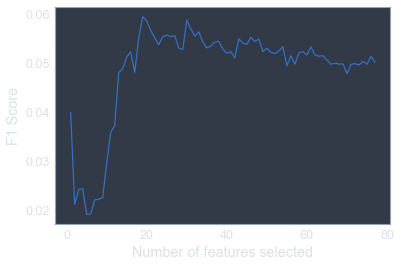

None


In [16]:
# RFE for full data

# Analysis
rfe_imp_fulwgt, subset_fulwgt = RFE_importance(X_train, y_train, bank_str = 'All Banks', method = 'wgt')
    
# Save final results
file_to_store = open("rfe_imp_fulwgt.pkl", "wb")
pickle.dump(rfe_imp_fulwgt, file_to_store)
file_to_store = open("subset_fulwgt.pkl", "wb")
pickle.dump(subset_fulwgt, file_to_store)
file_to_store.close()

Optimal number of features : 11
Best F1 Score: 0.27


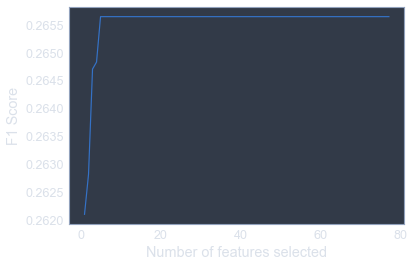

None


In [17]:
# RFE for full data

# Analysis
rfe_imp_fulrus, subset_fulrus = RFE_importance(X_train, y_train, bank_str = 'All Banks', method = 'rus')
    
# Save final results
file_to_store = open("rfe_imp_fulrus.pkl", "wb")
pickle.dump(rfe_imp_fulrus, file_to_store)
file_to_store = open("subset_fulrus.pkl", "wb")
pickle.dump(subset_fulrus, file_to_store)
file_to_store.close()

AMTRUST BANK
Optimal number of features : 57
Best F1 Score: 0.27


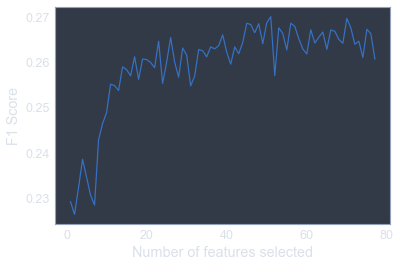

None
BANK OF AMERICA, N.A.
Optimal number of features : 69
Best F1 Score: 0.33


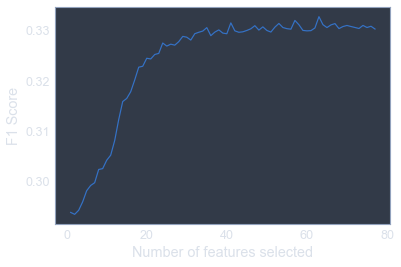

None
CHASE HOME FINANCE
Optimal number of features : 53
Best F1 Score: 0.31


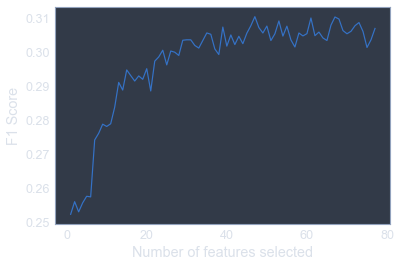

None
CITIMORTGAGE, INC.
Optimal number of features : 55
Best F1 Score: 0.27


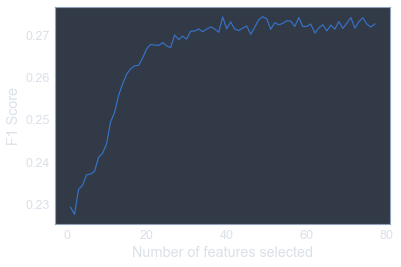

None
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB
Optimal number of features : 42
Best F1 Score: 0.43


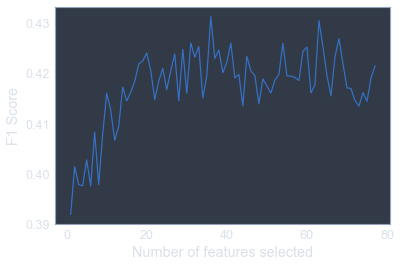

None
FIRST TENNESSEE BANK NATIONAL ASSOCIATION
Optimal number of features : 67
Best F1 Score: 0.23


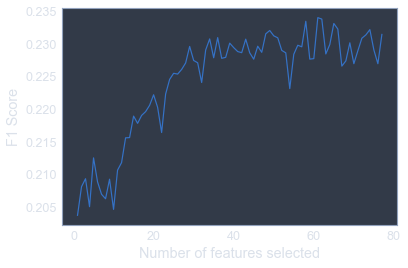

None
FLAGSTAR CAPITAL MARKETS CORPORATION
Optimal number of features : 61
Best F1 Score: 0.34


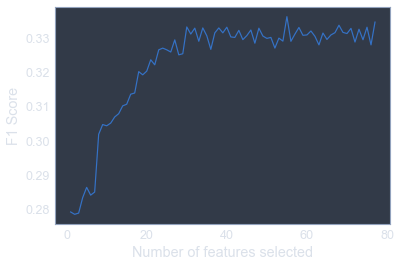

None
GMAC MORTGAGE
Optimal number of features : 77
Best F1 Score: 0.29


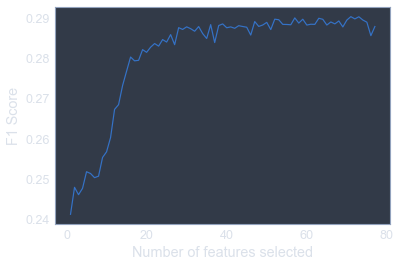

None
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
Optimal number of features : 65
Best F1 Score: 0.27


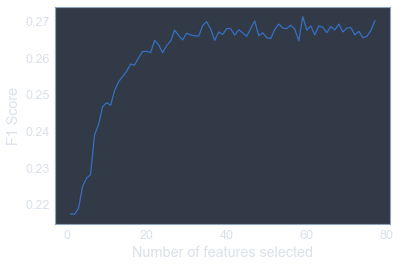

None
PNC BANK, N.A.
Optimal number of features : 76
Best F1 Score: 0.27


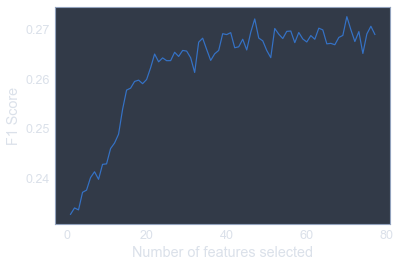

None
SUNTRUST MORTGAGE INC.
Optimal number of features : 53
Best F1 Score: 0.31


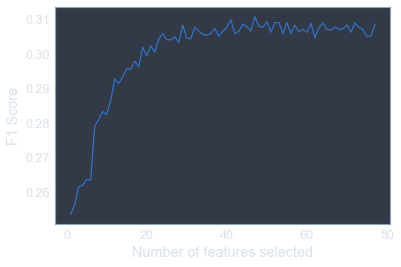

None


In [18]:
# RFE for balanced classes
rfe_imp_bal = {}
subset_bal = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    
    # Train
    y = Banks_y[bank_str]
    X = Banks_X[bank_str] 
    
    # Analysis
    rfe_imp_bal[bank_str], subset_bal[bank_str] = RFE_importance(X, y, 
                                                                 bank_str = bank_str, method = 'bal')
    
# Save final dictionary
file_to_store = open("rfe_imp_bal.pkl", "wb")
pickle.dump(rfe_imp_bal, file_to_store)
file_to_store = open("subset_bal.pkl", "wb")
pickle.dump(subset_bal, file_to_store)
file_to_store.close()

AMTRUST BANK
Optimal number of features : 24
Best F1 Score: 0.04


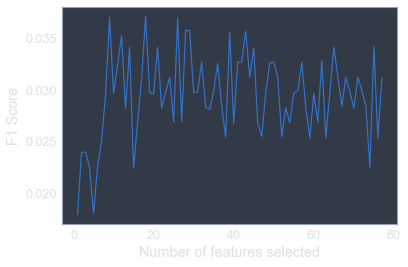

None
BANK OF AMERICA, N.A.
Optimal number of features : 38
Best F1 Score: 0.07


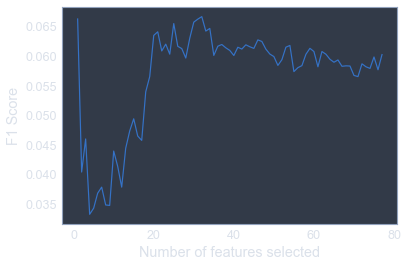

None
CHASE HOME FINANCE
Optimal number of features : 16
Best F1 Score: 0.10


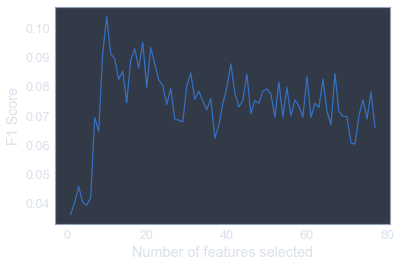

None
CITIMORTGAGE, INC.
Optimal number of features : 26
Best F1 Score: 0.04


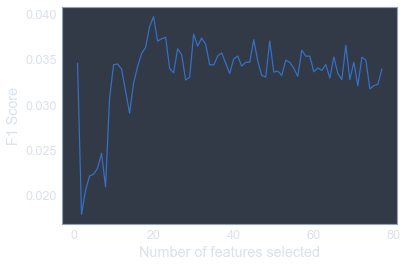

None
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB
Optimal number of features : 40
Best F1 Score: 0.21


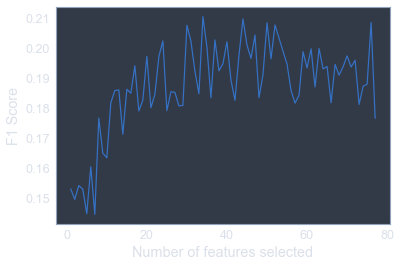

None
FIRST TENNESSEE BANK NATIONAL ASSOCIATION
Optimal number of features : 20
Best F1 Score: 0.04


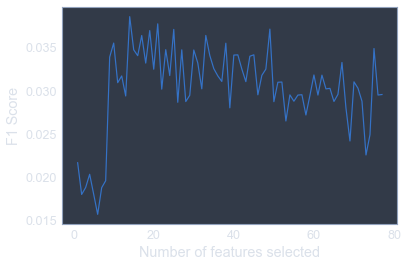

None
FLAGSTAR CAPITAL MARKETS CORPORATION
Optimal number of features : 17
Best F1 Score: 0.06


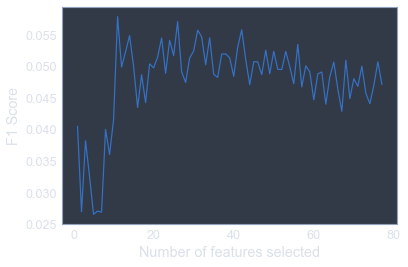

None
GMAC MORTGAGE
Optimal number of features : 25
Best F1 Score: 0.03


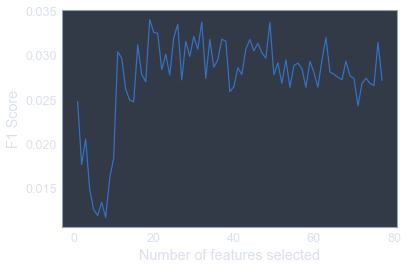

None
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
Optimal number of features : 22
Best F1 Score: 0.06


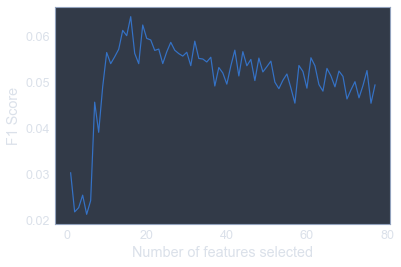

None
PNC BANK, N.A.
Optimal number of features : 37
Best F1 Score: 0.03


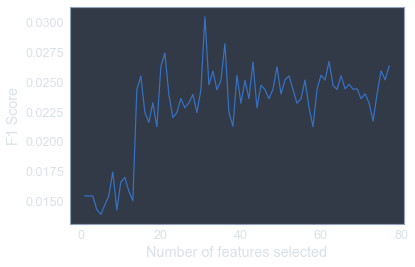

None
SUNTRUST MORTGAGE INC.
Optimal number of features : 32
Best F1 Score: 0.05


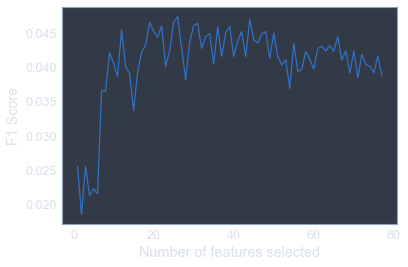

None


In [19]:
# RFE for weighted classes
rfe_imp_wgt = {}
subset_wgt = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    
    # Train
    y = Banks_y[bank_str]
    X = Banks_X[bank_str]
    
    # Analysis
    rfe_imp_wgt[bank_str], subset_wgt[bank_str] = RFE_importance(X, y, 
                                                                 bank_str = bank_str, method = 'wgt')
    
# Save final dictionary
file_to_store = open("rfe_imp_wgt.pkl", "wb")
pickle.dump(rfe_imp_wgt, file_to_store)
file_to_store = open("subset_wgt.pkl", "wb")
pickle.dump(subset_wgt, file_to_store)
file_to_store.close()

AMTRUST BANK
Optimal number of features : 11
Best F1 Score: 0.25


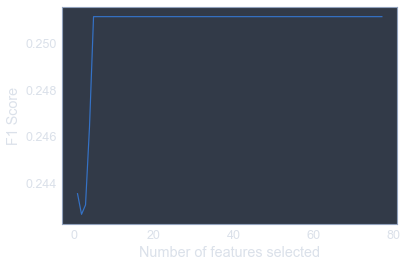

None
BANK OF AMERICA, N.A.
Optimal number of features : 10
Best F1 Score: 0.29


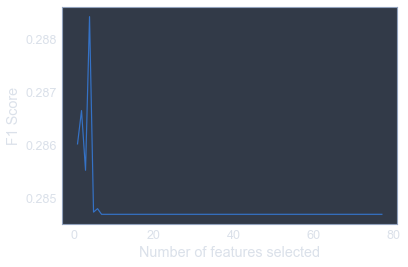

None
CHASE HOME FINANCE
Optimal number of features : 9
Best F1 Score: 0.27


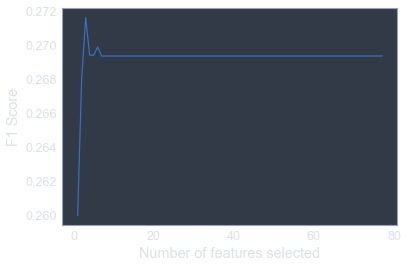

None
CITIMORTGAGE, INC.
Optimal number of features : 10
Best F1 Score: 0.23


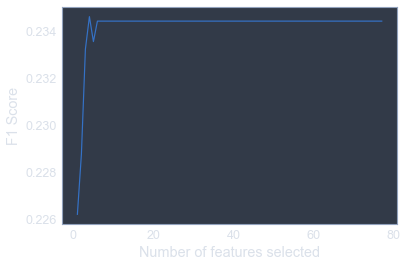

None
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB
Optimal number of features : 16
Best F1 Score: 0.41


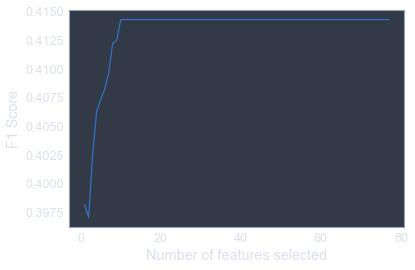

None
FIRST TENNESSEE BANK NATIONAL ASSOCIATION
Optimal number of features : 14
Best F1 Score: 0.21


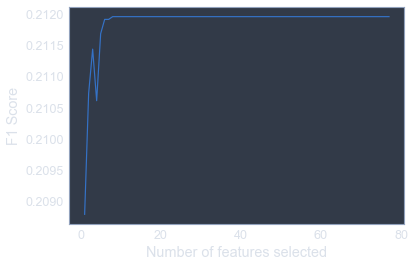

None
FLAGSTAR CAPITAL MARKETS CORPORATION


In [ ]:
# RFE for RUS classes
rfe_imp_rus = {}
subset_rus = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    
    # Train
    y = Banks_y[bank_str]
    X = Banks_X[bank_str]
        
    # Analysis
    rfe_imp_rus[bank_str], subset_rus[bank_str] = RFE_importance(X, y, 
                                                                 bank_str = bank_str, method = 'rus')
    
# Save final dictionary
file_to_store = open("rfe_imp_rus.pkl", "wb")
pickle.dump(rfe_imp_rus, file_to_store)
file_to_store = open("subset_rus.pkl", "wb")
pickle.dump(subset_rus, file_to_store)
file_to_store.close()

***

# Relative Importance

# Relative importance for full data
# Train
y = y_train
X = X_train
subset = subset_full
X = X.loc[:, subset]

# Analysis
rel_imp_full = relative_importance(X, y, bank_str = 'All Banks', method = 'bal')
    
# Save final results
file_to_store = open("rel_imp_full.pkl", "wb")
pickle.dump(rel_imp_full, file_to_store)
file_to_store.close()

# Relative importance for balanced classes
rel_imp_bal = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    
    # Train
    y = Banks_y[bank_str]
    X = Banks_X[bank_str]
    subset = subset_bal[bank_str]
    X = X.loc[:, subset]
    
    # Analysis
    rel_imp_bal[bank_str] = relative_importance(X, y, 
                                                bank_str = bank_str, method = 'bal')
    
# Save final dictionary
file_to_store = open("rel_imp_bal.pkl", "wb")
pickle.dump(rel_imp_bal, file_to_store)
file_to_store.close()

# Relative importance for weighted classes
rel_imp_wgt = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    
    # Train
    y = Banks_y[bank_str]
    X = Banks_X[bank_str] 
    subset = subset_wgt[bank_str]
    X = X.loc[:, subset]
    
    # Analysis  
    rel_imp_bal[bank_str] = relative_importance(X, y, 
                                                bank_str = bank_str, method = 'wgt')
    
# Save final dictionary
file_to_store = open("rel_imp_wgt.pkl", "wb")
pickle.dump(rel_imp_wgt, file_to_store)
file_to_store.close()

# Relative importance for RUS classes
rel_imp_rus = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    
    # Train
    y = Banks_y[bank_str]
    X = Banks_X[bank_str]
    subset = subset_rus[bank_str]
    X = X.loc[:, subset]
    
    # Analysis
    rel_imp_rus[bank_str] = relative_importance(X, y, 
                                                bank_str = bank_str, method = 'rus')
    
# Save final dictionary
file_to_store = open("rel_imp_rus.pkl", "wb")
pickle.dump(rel_imp_rus, file_to_store)
file_to_store.close()

***

# Vote by Committee

In [ ]:
bal = BalancedRandomForestClassifier(n_estimators=50, random_state=2020, max_features='sqrt', 
                                     replacement=False, n_jobs=-1)
wgt = RandomForestClassifier(n_estimators=50, random_state=2020, max_features='sqrt', 
                             class_weight={1: 0.08, 0: 0.02}, n_jobs=-1) 
rus = RUSBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=2020)

# Full Data
y_full = y_train
X_full = X_train
X_test_full = X_test

# Subset
subset = subset_full
X_full = X_full.loc[:, subset]
X_test_full = X_test_full.loc[:, subset]

# Standardize Vars
X_cols = X_full.columns
scaler = StandardScaler().fit(X_full)
X_full = scaler.transform(X_full)
X_test_full = scaler.transform(X_test_full)

# Model Bal
bal.fit(X_full, y_full)
clf = pickle.dumps(bal)
fulbal_models = pickle.loads(clf)
fulbal_proba = pd.DataFrame(fulbal_models.predict_proba(X_test_full)).iloc[:,1]
fulbal_pred = fulbal_proba.map(lambda x: 1 if x >= 0.5 else 0)
fulbal_scores = f1_score(y_test, full_pred)
print(fulbal_scores)

# Model Wgt
wgt.fit(X_full, y_full)
clf = pickle.dumps(wgt)
fulwgt_models = pickle.loads(clf)
fulwgt_proba = pd.DataFrame(fulwgt_models.predict_proba(X_test_full)).iloc[:,1]
fulwgt_pred = fulwgt_proba.map(lambda x: 1 if x >= 0.5 else 0)
fulwgt_scores = f1_score(y_test, full_pred)
print(fulwgt_scores)

# Model Rus
rus.fit(X_full, y_full)
clf = pickle.dumps(rus)
fulrus_models = pickle.loads(clf)
fulrus_proba = pd.DataFrame(fulrus_models.predict_proba(X_test_full)).iloc[:,1]
fulrus_pred = fulrus_proba.map(lambda x: 1 if x >= 0.5 else 0)
fulrus_scores = f1_score(y_test, full_pred)
print(fulrus_scores)

In [ ]:
def model_banks(Banks_X, Banks_y, Banks_X_test, bank_str, subset, clf):
    # Dictionaries
    bnk_models = {}
    bnk_proba = {}
    bnk_pred = {}
    bnk_scores = {}

    # Load Bank Data
    y = Banks_y[bank_str]
    X = Banks_X[bank_str] 
    X_test_bnk = Banks_X_test[bank_str]
    
    # Subset
    subset = subset[bank_str]
    X = X.loc[:, subset]
    X_test_bnk = X_test_bnk.loc[:, subset]
        
    # Standardize Vars
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X_test_bnk = scaler.transform(X_test_bnk)

    # Model
    bnk_models[bank_str] = clf.fit(X, y)
    bnk_proba[bank_str] = pd.DataFrame(bnk_models[bank_str].predict_proba(X_test_bnk)).iloc[:,1]
    bnk_pred[bank_str] = bnk_proba[bank_str].map(lambda x: 1 if x >= 0.5 else 0)
    bnk_scores[bank_str] = roc_auc_score(Banks_y_test[bank_str], bnk_pred[bank_str])
    print(bnk_scores[bank_str])
    
    return bnk_pred[bank_str]
    
clfs = []
votes = pd.DataFrame()
for bank_str in ['AMTRUST BANK']:  
    print(bank_str)
    votes.loc[:,'bal'] = model_banks(Banks_X, Banks_y, Banks_X_test, bank_str, subset_bal, bal)
    votes.loc[:,'wgt'] = model_banks(Banks_X, Banks_y, Banks_X_test, bank_str, subset_wgt, wgt)
    votes.loc[:,'rus'] = model_banks(Banks_X, Banks_y, Banks_X_test, bank_str, subset_rus, rus)
    
    # Full Data
    subset = subset_full
    X_test_bnk = Banks_X_test[bank_str].loc[:, subset]
    scaler = StandardScaler().fit(X_full)
    X_test_bnk = scaler.transform(X_test_bnk)
    
    # Bal
    votes.loc[:,'fulbal'] = pd.DataFrame(fulbal_models.predict_proba(X_test_bnk)).iloc[:,1]
    votes.loc[:,'fulbal'] = votes.loc[:,'fulbal'].map(lambda x: 1 if x >= 0.5 else 0)
    
    # Wgt
    votes.loc[:,'fulwgt'] = pd.DataFrame(fulwgt_models.predict_proba(X_test_bnk)).iloc[:,1]
    votes.loc[:,'fulwgt'] = votes.loc[:,'fulwgt'].map(lambda x: 1 if x >= 0.5 else 0)    
    
    # Rus
    votes.loc[:,'fulrus'] = pd.DataFrame(fulrus_models.predict_proba(X_test_bnk)).iloc[:,1]
    votes.loc[:,'fulrus'] = votes.loc[:,'fulrus'].map(lambda x: 1 if x >= 0.5 else 0)     

In [ ]:
votes.loc[:,'maj'] = ( votes.iloc[:,0:4].sum(axis=1) / 4 ).map(lambda x: 1 if x >= 0.5 else 0)
votes.loc[:,'true'] = np.array(Banks_y_test['AMTRUST BANK'])
print(np.mean(votes.loc[:,'maj']))
display(votes.head(25))

In [ ]:
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'bal']))
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'wgt']))
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'rus']))
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'fulbal']))
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'fulwgt']))
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'fulrus']))
print(roc_auc_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'maj']))

In [ ]:
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'bal']))
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'wgt']))
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'rus']))
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'fulbal']))
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'fulwgt']))
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'fulrus']))
print(f1_score(Banks_y_test['AMTRUST BANK'], votes.loc[:,'maj']))